Config

In [1]:
DATA_DIR = 'tsplib-data'
PROBLEMS_DIR = 'problems'
FEATURES_DIR = 'npy'

# See the functions dict (line 478) in ./optlearn/optlearn/feature/features.py
# For any feature computation function named compute_fX_edges, you can add fX here
DESIRED_EDGE_FEATURES = ['fg']
# DESIRED_EDGE_FEATURES = ['fa', 'fb', 'fc', 'fd', 'fe', 'ff', 'fg', 'fi', 'fj']

USE_PAPER_FG = True

# Even if the features already exist, overwrite them
OVERRIDE_FEATURES = True
if OVERRIDE_FEATURES:
	print('Warning: Any feature weights already computed may be overwritten.')

# Choose the layout function for arranging nodes in the visualizations
# Recommended choices: nx.spiral_layout, nx.spring_layout
import networkx as nx
VIZ_LAYOUT = nx.spiral_layout

Building features

In [2]:
import os
DATA_PATH = os.path.join(os.path.abspath(''), DATA_DIR)
PROBLEMS_PATH = os.path.join(DATA_PATH, PROBLEMS_DIR)
FEATURES_PATH = os.path.join(DATA_PATH, FEATURES_DIR)

import optlearn.mst.mst_model
optlearn.mst.mst_model.use_paper_fg = USE_PAPER_FG

from optlearn.experiments.build_data import build_features
build_features(
	FEATURES_PATH,
	PROBLEMS_PATH,
	DESIRED_EDGE_FEATURES,
	override=OVERRIDE_FEATURES
)


Status:
Directory Status: Checked/Built


Iteration 1 of 2
Iteration 2 of 2
Problem 1 of 1 completed

Status:
Directory Status: Checked/Built
Features Status: Checked/Built/Written
Current Problem: N/A


Done! :D


Printing and visualizing features

small4_undirected.tsp:


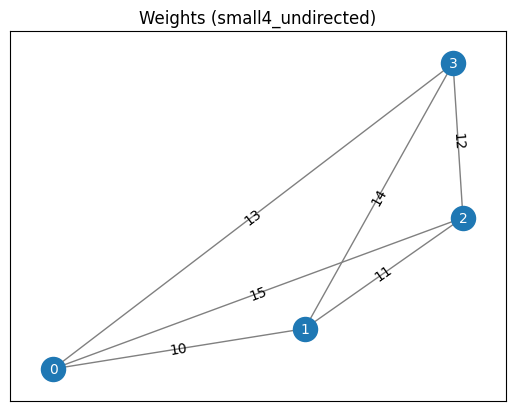

['fg']
0 (0, 1): [1.]
1 (0, 2): [0.5]
2 (0, 3): [0.5]
3 (1, 2): [1.]
4 (1, 3): [0.5]
5 (2, 3): [1.]


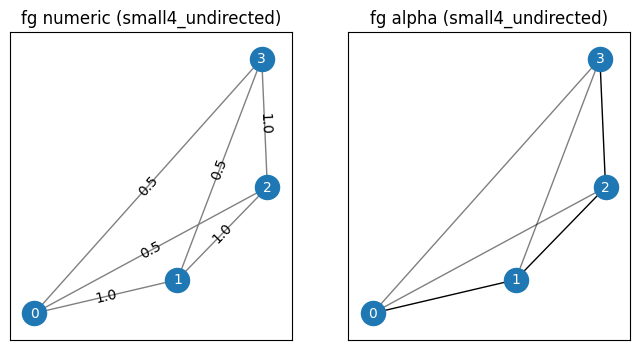

In [3]:
from optlearn.data.data_utils import dataLoader
# FULL_FEATURE_NAMES = [f'compute_{name}_edges' for name in DESIRED_EDGE_FEATURES]
loader = dataLoader([]) # how can we input the data_pairs if we don't have the data yet?

import networkx as nx
from optlearn.graph_utils import get_edges, get_weights
from optlearn.io_utils import optObject

# Note: We're not using optlearn.plotting.plot_graph because it isn't very 
# helpful here - it doesn't show numerical values
from optlearn.plotting import plot_graph
import matplotlib.pyplot as plt

PYPLOT_WIDTH_INCHES = 4 * 2
PYPLOT_HEIGHT_INCHES = 4 * len(DESIRED_EDGE_FEATURES)
ARC_RADIUS = 0.15

def draw_full_graph(ax=None, use_alpha=False):
	nx.draw_networkx_nodes(G, pos, ax=ax)
	nx.draw_networkx_labels(G, pos, font_size=10, font_color='w', ax=ax)
	connectionstyle = 'arc3' + (f',rad={ARC_RADIUS}' if G.is_directed() else '')
	nx.draw_networkx_edges(
		G,
		pos,
		edge_color=('black' if use_alpha else 'grey'),
		ax=ax,
		alpha=(features_data[:,feature_idx] if use_alpha else 1),
		connectionstyle=connectionstyle
	)
	if not use_alpha:
		nx.draw_networkx_edge_labels(
			G,
			pos,
			labels,
			label_pos=(0.3 if G.is_directed() else 0.5),
			bbox={"alpha": 0},
			ax=ax,
			connectionstyle=connectionstyle
		)

for problem_file_name in os.listdir(PROBLEMS_PATH):
	# 2. Prints features
	print(f'{problem_file_name}:')
	problem_name = problem_file_name.removesuffix('.tsp')
	feature_file_name = problem_name + '.npy'
	features_data = loader.load_features([
		os.path.join(FEATURES_PATH, feature, feature_file_name)
		for feature in DESIRED_EDGE_FEATURES])

	# 3. Plots each feature as a separate graph
	problem_file_path = os.path.join(PROBLEMS_PATH, problem_file_name)
	# Returns graph with N(N - 1) edges (all directed edges besides loops)
	G = optObject().read_problem_from_file(problem_file_path).get_graph()
	edges = get_edges(G)
	weights = get_weights(G)
	pos = VIZ_LAYOUT(G)
	
	labels = {}
	for edge_idx, edge in enumerate(edges):
		labels[edge] = weights[edge_idx]
	draw_full_graph()
	plt.title(f'Weights ({problem_name})')
	plt.show()

	# Based on
	# https://networkx.org/documentation/latest/auto_examples/drawing/plot_multigraphs.html#sphx-glr-auto-examples-drawing-plot-multigraphs-py
	fig, ax = plt.subplots(len(DESIRED_EDGE_FEATURES), 2)
	# Standardizes ax as a 2D list
	if len(DESIRED_EDGE_FEATURES) == 1:
		ax = [ax]
	print(DESIRED_EDGE_FEATURES)
	for edge_idx, edge in enumerate(edges):
		print(f'{edge_idx} {edge}: {features_data[edge_idx]}')
	for feature_idx, feature in enumerate(DESIRED_EDGE_FEATURES):
		labels = {}
		for edge_idx, edge in enumerate(edges):
			labels[edge] = round(features_data[edge_idx][feature_idx], 3)
		
		ax_numeric: plt.Axes = ax[feature_idx][0]
		draw_full_graph(ax=ax_numeric)
		ax_numeric.set_title(f'{feature} numeric ({problem_name})')

		ax_alpha: plt.Axes = ax[feature_idx][1]
		draw_full_graph(ax=ax_alpha, use_alpha=True)
		ax_alpha.set_title(f'{feature} alpha ({problem_name})')
	fig.set_size_inches(PYPLOT_WIDTH_INCHES, PYPLOT_HEIGHT_INCHES)
	plt.show()
